In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os

from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from settings import colors, titles, ax_label_size, tick_label_size, letter_size, legend_size


In [2]:
exp = "10"
base_path = f"/storage/noise_correlations/exp{exp}"

In [3]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')

# Extra datasets
# pvc11_2_path = os.path.join(base_path, 'exp09_2_pvc11_15_1000_1000.h5')
# pvc11_3_path = os.path.join(base_path, 'exp09_3_pvc11_15_1000_1000.h5')

In [4]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

# Extra datasets
# pvc11_2 = h5py.File(pvc11_2_path, 'r')
# pvc11_3 = h5py.File(pvc11_3_path, 'r')

In [5]:
n_max_units = ret2['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [6]:
groups = [
    'v_lfi',
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
labels = [
    'Observed',
    'Shuffle',
    'Uniform',
    'FA'
]

percentile_groups = [
    'p_s_lfi',
    'p_u_lfi',
    'p_fa_lfi'
]
value_groups = [
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
lfi_models = [
    'observed',
    'shuffle',
    'uniform',
    'fa'
]
models = [
    'shuffle',
    'uniform',
    'fa'
]
labels2 = [
    'Shuffle',
    'Uniform',
    'FA'
]

In [7]:
median_lfis = dict()
for idx, result in enumerate(results):
    # Plot observed LFI
    for group, model in zip(groups, lfi_models):
        if group == 'v_lfi':
            median_lfis[(idx, group)] = result[group][:]
        else:
            median_lfis[(idx, group)] = np.median(result[group], axis=2)
            # Alternative: take statistics across all dim-stims and repeats
            # values = np.reshape(result[group], (dims.size, -1))

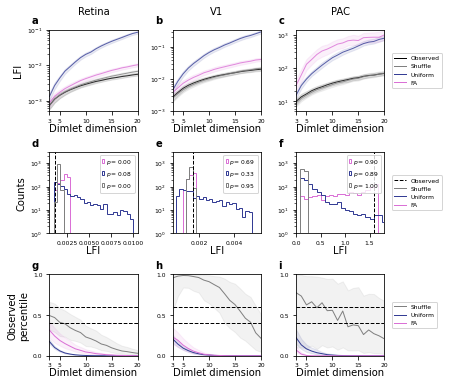

In [8]:
"""
Figure Settings
"""
# Subplot adjustments
wspace = 0.4
hspace = 0.5
title_pad = 15
# Label adjustments
title_size = ax_label_size
subplot_x = -0.18
subplot_y = 1.12
# Line settings
linewidth = 1
line_alpha = 0.8
obs_lw = 1
# Fill settings
fill_alpha = 0.1
# Legend settings
handlelength = 0.3
handletextpad = 0.3
# Percentile bounds for curves
percentile_lower = 40
percentile_upper = 60
bins = [
    np.linspace(0.001, 0.01, 25),
    np.linspace(0.0005, 0.005, 25),
    np.linspace(0, 2, 25)
]
"""
Figure 3
"""
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
plt.subplots_adjust(wspace=wspace, hspace=hspace)

"""
First Row: LFI values over dimension
"""
# Enumerate over results
for idx, (result, ax) in enumerate(zip(results, axes[0])):
    # Plot observed LFI
    for group, model in zip(groups, lfi_models):
        color = colors[model]
        values = median_lfis[(idx, group)]
        median = np.median(values, axis=1)
        lower, median, upper = np.percentile(values,
                                             q=[percentile_lower, 50, percentile_upper]
                                             , axis=1)
        # Fill region between percentile bounds
        ax.fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=color,
            alpha=fill_alpha)
        ax.plot(
            dims,
            median,
            linewidth=linewidth,
            color=color,
            alpha=line_alpha)

# Set bounds
axes[0, 0].set_ylim(bottom=5e-4, top=1e-1)
axes[0, 1].set_ylim(bottom=1e-3)
axes[0, 2].set_ylim(bottom=5)

# Set axis limits, scales, and labels
for (ax, title) in zip(axes[0], titles):
    ax.set_xlim([3, 20])
    ax.set_yscale('log')
    ax.set_xticks([3, 5, 10, 15, 20])
    
    ax.set_xlabel(r'Dimlet dimension', fontsize=ax_label_size, labelpad=0)
    ax.set_title(title, fontsize=title_size, pad=title_pad)
axes[0, 0].set_ylabel(r'LFI', fontsize=ax_label_size)

"""
Second Row: Example distributions
"""
dim_idx = 0
dimstim_idxs = [4044, 2011, 1766]

for idx, result in enumerate(results):
    dimstim_idx = dimstim_idxs[idx]
    lfi = result['v_lfi'][dim_idx, dimstim_idx]
    
    axes[1, idx].axvline(
        lfi,
        color='black',
        linestyle='--',
        lw=obs_lw)

    for (v_group, p_group, model) in zip(reversed(value_groups), reversed(percentile_groups), reversed(models)):
        values = result[v_group][dim_idx, dimstim_idx]
        axes[1, idx].hist(
            values,
            color=colors[model],
            histtype='step',
            linewidth=linewidth,
            bins=bins[idx],
            label=f'$p={result[p_group][dim_idx, dimstim_idx]:0.2f}$')
        
# Set bounds
axes[1, 0].set_xlim([0.0005, 0.0105])
axes[1, 1].set_xlim([0.0005, 0.0055])
axes[1, 2].set_xlim([0, 1.8])

#axes[1, 0].set_xticks([0.0012, 0.0016, 0.0020])
#axes[1, 1].set_xticks([0.0007, 0.0010, 0.0013])
#axes[1, 2].set_xticks([0, 2, 4, 6, 8])

axes[1, 0].set_yscale('log')
axes[1, 0].set_ylim([1, 3e3])
axes[1, 1].set_yscale('log')
axes[1, 1].set_ylim([1, 3e3])
axes[1, 2].set_yscale('log')
axes[1, 2].set_ylim([1, 3e3])

#axes[1, 0].set_yticks([0, 100, 200])
#axes[1, 1].set_yticks([0, 100, 200])
#axes[1, 2].set_yticks([0, 200, 400, 600])

for ax in axes[1]:
    ax.tick_params(labelsize=tick_label_size)
    ax.set_xlabel(r'LFI', fontsize=ax_label_size, labelpad=0)
axes[1, 0].set_ylabel(r'Counts', fontsize=ax_label_size)

"""
Third Row
"""
# Enumerate over results
for idx, result in enumerate(results):
    # Iterate over null models
    for group, model in zip(percentile_groups, models):
        # Calculate median and bounds for each null model
        percentiles = result[group][:]
        lower, median, upper = np.percentile(percentiles,
                                             q=[percentile_lower, 50, percentile_upper],
                                             axis=1)
        # Fill region between percentile bounds
        axes[2, idx].fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=colors[model],
            alpha=fill_alpha)
        axes[2, idx].plot(
            dims,
            median,
            linewidth=linewidth,
            color=colors[model])
    axes[2, idx].axhline(percentile_lower/100., 0, 1, lw=1, ls='--', c='k')
    axes[2, idx].axhline(percentile_upper/100., 0, 1, lw=1, ls='--', c='k')

# Set axis limits, scales, and labels
for ax in axes[2]:
    ax.set_xlim([3, 20])
    ax.set_ylim([0, 1])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([0, .5, 1])
    ax.tick_params(labelsize=tick_label_size)
    
    ax.set_xlabel('Dimlet dimension', fontsize=ax_label_size, labelpad=0)
axes[2, 0].set_ylabel('Observed\npercentile', fontsize=ax_label_size)

# First Row
# Create legend in last axis spot
for model, label in zip(['observed'] + models, labels):
    axes[0, -1].plot([], [], color=colors[model], label=label, linewidth=linewidth)
axes[0, -1].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})

# Second Row
# Create subplot legends
for col in range(3):
    axes[1, col].legend(
        loc='upper right',
        handlelength=handlelength,
        handletextpad=handletextpad,
        ncol=1,
        columnspacing=0.5,
        prop={'size': legend_size})

# Create legend outside of plot
ghost_ax = axes[1, 2].twinx()
ghost_ax.axis('off')
ghost_ax.plot([], [], color=colors['observed'], label=r'Observed',
              linewidth=1, linestyle='--')
for model, label in zip(models, labels2):
    ghost_ax.plot([], [], color=colors[model], label=label, linewidth=linewidth)
    
ghost_ax.legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})

# Third Row
# Create legend in last axis spot
for model, label in zip(models, labels2):
    axes[2, -1].plot([], [], color=colors[model], label=label, linewidth=linewidth)
axes[2, -1].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})

# Apply subplot labels
lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
c = 0
for ii in range(3):
    for jj in range(3):
        ax = axes[ii, jj]
        ax.text(-.2, 1.07, lets[c], size=letter_size, fontweight='bold', transform=ax.transAxes)
        c += 1
for ax in axes.ravel():
    ax.tick_params(labelsize=tick_label_size)

plt.savefig('figure3.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figure3.jpg', dpi=300, bbox_inches='tight')
plt.show()